In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import netCDF4
from netCDF4 import Dataset
import math
import os
import datetime as dt
import seaborn as sns
import missingno as msno

In [4]:
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
#from sklearn.linear_model import ElasticNet
#from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [5]:
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

C:\Users\HPHP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [7]:
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)

## Meteorological Data

In [139]:
df = pd.read_csv('HistoricalData/HistMetData_46035.csv')
df.head()

,Unnamed: 0,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2014-07-03 01:50:00,348.0,2.8,4.0,0.78,10.0,5.89,158.0,1011.6,8.2,8.9,999.0,NaN,99.0
1,2014-07-03 02:50:00,5.0,2.4,3.3,0.78,10.0,5.87,171.0,1011.4,8.4,9.1,999.0,NaN,99.0
2,2014-07-03 03:50:00,360.0,1.9,2.8,0.90,10.0,6.07,169.0,1011.6,8.5,9.1,999.0,NaN,99.0
3,2014-07-03 04:50:00,360.0,1.4,2.5,0.97,10.0,6.03,159.0,1011.5,8.4,9.1,999.0,NaN,99.0
4,2014-07-03 05:50:00,326.0,1.6,2.2,1.00,10.0,5.95,161.0,1011.5,8.1,9.0,999.0,NaN,99.0


In [140]:
df.shape

(36907, 14)

In [141]:
df.rename(columns={'Unnamed: 0':'DateTime'},inplace=True)
df.head()

,DateTime,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2014-07-03 01:50:00,348.0,2.8,4.0,0.78,10.0,5.89,158.0,1011.6,8.2,8.9,999.0,NaN,99.0
1,2014-07-03 02:50:00,5.0,2.4,3.3,0.78,10.0,5.87,171.0,1011.4,8.4,9.1,999.0,NaN,99.0
2,2014-07-03 03:50:00,360.0,1.9,2.8,0.90,10.0,6.07,169.0,1011.6,8.5,9.1,999.0,NaN,99.0
3,2014-07-03 04:50:00,360.0,1.4,2.5,0.97,10.0,6.03,159.0,1011.5,8.4,9.1,999.0,NaN,99.0
4,2014-07-03 05:50:00,326.0,1.6,2.2,1.00,10.0,5.95,161.0,1011.5,8.1,9.0,999.0,NaN,99.0


In [142]:
df.replace([99.0,999.0, 9999.0],np.NAN,inplace=True)

In [143]:
df.describe()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
count,26454.000000,26517.000000,26517.000000,36906.000000,36906.000000,36906.000000,36837.000000,36633.000000,33327.000000,33805.000000,0.0,0.0,0.0
mean,172.632721,8.024313,9.937768,2.708731,9.145808,6.533181,166.276488,1005.617293,5.170870,6.610655,NaN,NaN,NaN
std,107.520227,3.785336,4.636278,1.594426,2.346735,1.275717,101.183710,13.904243,4.193174,3.090598,NaN,NaN,NaN
min,1.000000,0.000000,0.100000,0.380000,2.600000,3.280000,1.000000,940.800000,-6.000000,2.100000,NaN,NaN,NaN
25%,74.000000,5.300000,6.500000,1.520000,7.690000,5.570000,73.000000,997.100000,2.100000,3.700000,NaN,NaN,NaN
50%,168.000000,7.800000,9.600000,2.350000,9.090000,6.390000,180.000000,1007.000000,4.900000,6.000000,NaN,NaN,NaN
75%,266.000000,10.500000,12.900000,3.550000,10.810000,7.360000,242.000000,1015.000000,9.000000,9.500000,NaN,NaN,NaN
max,360.000000,24.600000,31.300000,12.260000,21.050000,12.410000,360.000000,1042.700000,13.100000,13.200000,NaN,NaN,NaN


In [144]:
df.drop(columns=['VIS','TIDE'],axis=1,inplace=True)

In [145]:
df.describe()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP
count,26454.000000,26517.000000,26517.000000,36906.000000,36906.000000,36906.000000,36837.000000,36633.000000,33327.000000,33805.000000,0.0
mean,172.632721,8.024313,9.937768,2.708731,9.145808,6.533181,166.276488,1005.617293,5.170870,6.610655,NaN
std,107.520227,3.785336,4.636278,1.594426,2.346735,1.275717,101.183710,13.904243,4.193174,3.090598,NaN
min,1.000000,0.000000,0.100000,0.380000,2.600000,3.280000,1.000000,940.800000,-6.000000,2.100000,NaN
25%,74.000000,5.300000,6.500000,1.520000,7.690000,5.570000,73.000000,997.100000,2.100000,3.700000,NaN
50%,168.000000,7.800000,9.600000,2.350000,9.090000,6.390000,180.000000,1007.000000,4.900000,6.000000,NaN
75%,266.000000,10.500000,12.900000,3.550000,10.810000,7.360000,242.000000,1015.000000,9.000000,9.500000,NaN
max,360.000000,24.600000,31.300000,12.260000,21.050000,12.410000,360.000000,1042.700000,13.100000,13.200000,NaN


In [146]:
df.isna().any()

DateTime    False
WDIR         True
WSPD         True
GST          True
WVHT         True
DPD          True
APD          True
MWD          True
PRES         True
ATMP         True
WTMP         True
DEWP         True
dtype: bool

#### All the columns have missing data

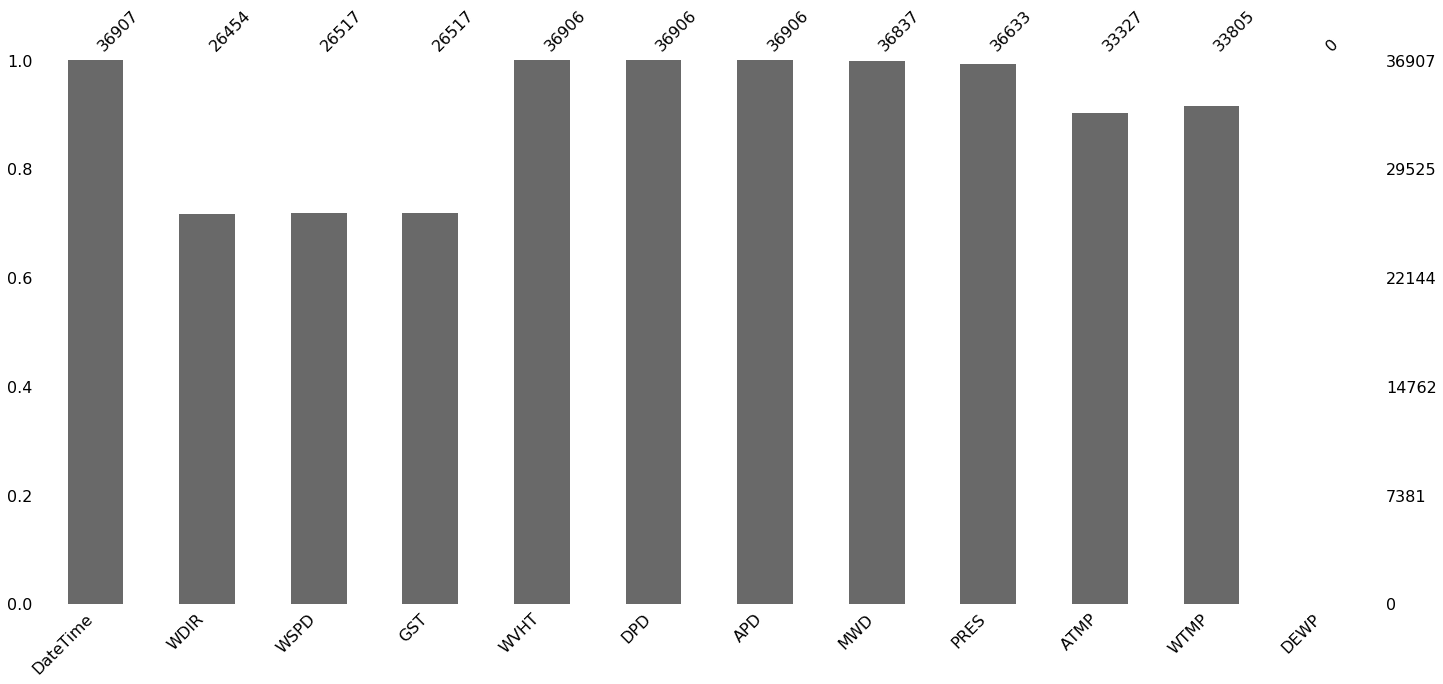

In [147]:
msno.bar(df)

In [ ]:
df.drop(columns=['MWD','DEWP'],axis=1,inplace=True)

In [ ]:
msno.bar(df)

In [ ]:
df_dropped = df.dropna()
df_dropped.describe()

In [ ]:
df_dropped.shape

## Ocean Currents Data

In [4]:
#Reading list of stations with available currents data
stations = pd.read_csv('19_stations.csv',skipinitialspace=True)

#Converting Longitude west to east, to match with currents data notation
stations['lon'] = 360-stations['lon']

# Creating a new dataset to store all currents data
test = stations.copy()

#Pivoting the 'Station' column to make each station a column name
test = pd.pivot_table(test, columns=['Station'])

#dropping longitude & latitude values. Instead, we'll use original 'Stations' table for the longitude and latitudes
test.drop(test.index, inplace=True)

#Adding 19 new columns to make 38 multi-index columns (2 for each of the 19 stations)
test = pd.concat([test,test.reindex(columns=list(range(19)))])
columns=stations['Station'].values
velocities = ['u','v']

# Creating multi-index columns, u, v for each of the 19 stations
test.columns=pd.MultiIndex.from_product([columns,velocities])

test

Empty DataFrame
Columns: [(46015, u), (46015, v), (46027, u), (46027, v), (46022, u), (46022, v), (46014, u), (46014, v), (PTAC1, u), (PTAC1, v), (46002, u), (46002, v), (46013, u), (46013, v), (46026, u), (46026, v), (46012, u), (46012, v), (46042, u), (46042, v), (46028, u), (46028, v), (46011, u), (46011, v), (PTGC1, u), (PTGC1, v), (46054, u), (46054, v), (46053, u), (46053, v), (46069, u), (46069, v), (46025, u), (46025, v), (46047, u), (46047, v), (46086, u), (46086, v)]
Index: []

[0 rows x 38 columns]

In [5]:
for fileName in os.listdir('CurrentsData/'):
    fileDate = fileName[-13:-3]
    try:
        dataset = Dataset('CurrentsData/'+fileName)
        u = dataset.variables['u']
        v = dataset.variables['v']
        lon_array = dataset.variables['lon'][:]
        lat_array = dataset.variables['lat'][:]
        time_array = dataset.variables['time'][:]
        depth_array = dataset.variables['depth'][:]

        test = test.append(pd.Series(name=fileDate))
        for i, row in stations.iterrows():

            lat_index = np.abs(lat_array - row['lat']).argmin()
            lon_index = np.abs(lon_array - row['lon']).argmin()
            dep_index = np.abs(depth_array - 0).argmin()
            time_index = np.abs(time_array - 1.0).argmin()

            if(lat_array[lat_index] - row['lat'] <= 0.1):
                u_value = u[:,dep_index,lat_index,lon_index]
            else:
                u_value = np.NAN

            if(lon_array[lon_index] - row['lon'] <= 0.1):
                v_value = v[:,dep_index,lat_index,lon_index]
            else:
                v_value = np.NAN

            test.at[fileDate, (row['Station'],'u')] = u_value
            test.at[fileDate, (row['Station'],'v')] = v_value
    except:
        print("Unable to process the file",fileName)
    finally:
        dataset.close()
    

Unable to process the file ca_subCA_bio_2014120309.nc
Unable to process the file ca_subCA_bio_2015021715.nc
Unable to process the file ca_subCA_bio_2016040321.nc


C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element t

C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element t

C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element t

C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element to nan.
  engine.set_value(series._values, index, value)
C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\frame.py:2579: UserWarning: Warning: converting a masked element t

In [6]:
test.shape

(6361, 38)

In [7]:
test.head()

46015               46027               46022            \
                   u         v         u         v         u         v   
2013010103  0.022879 -0.176103 -0.042675 -0.117706 -0.159065 -0.225282   
2013010109 -0.132579 -0.133023 -0.061303  0.168611 -0.339585 -0.352252   
2013010115  0.000021  0.156359  0.033921 -0.011597 -0.288465 -0.099120   
2013010121 -0.024741 -0.024946  0.017932 -0.037752 -0.269262 -0.288108   
2013010203 -0.026595 -0.113011  0.015125 -0.198444 -0.281528 -0.245974   

               46014               PTAC1              ...        46053  \
                   u         v         u         v    ...            u   
2013010103  0.012454 -0.596346 -0.098758  0.189663    ...     0.127786   
2013010109 -0.478630 -0.030841  0.022117  0.411831    ...    -0.080875   
2013010115  0.053899 -0.074639 -0.093680  0.019036    ...    -0.025048   
2013010121 -0.024331  0.064643 -0.048259  0.382174    ...    -0.132510   
2013010203 -0.113954  0.107819  0.028518  0.155182    ...     0.138505   

                         46069               46025               46047  \
                   v         u         v         u         v         u   
2013010103 -0.052983  0.145036 -0.018463  0.112119 -0.080323  0.257006   
2013010109 -0.017088  0.075092 -0.045910 -0.109762 -0.059036 -0.059332   
2013010115  0.029185  0.153242 -0.006796  0.018986  0.164402  0.170121   
2013010121  0.055814 -0.070026 -0.067319 -0.120629 -0.004231 -0.116132   
2013010203 -0.044682  0.162526 -0.072071  0.131868 -0.019968  0.154311   

                         46086            
                   v         u         v  
2013010103 -0.198736  0.014944 -0.174077  
2013010109 -0.177118 -0.151422 -0.059866  
2013010115 -0.068729 -0.050464  0.098153  
2013010121 -0.275085 -0.001019 -0.118416  
2013010203 -0.064177 -0.053546 -0.084577  

[5 rows x 38 columns]

In [8]:
test.isna().sum().any()

True

In [9]:
test[test.isnull().any(axis=1)]

46015     46027     46022     46014     PTAC1     ... 46053      \
               u   v     u   v     u   v     u   v     u   v ...     u   v   
2014070109   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2015101415   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2017110103   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2018021115   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2018041109   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2018061409   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2018062309   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   
2018072415   NaN NaN   NaN NaN   NaN NaN   NaN NaN   NaN NaN ...   NaN NaN   

           46069     46025     46047     46086      
               u   v     u   v     u   v     u   v  
2014070109   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2015101415   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2017110103   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2018021115   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2018041109   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2018061409   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2018062309   NaN NaN   NaN NaN   NaN NaN   NaN NaN  
2018072415   NaN NaN   NaN NaN   NaN NaN   NaN NaN  

[8 rows x 38 columns]

In [10]:
test.shape
test.dropna(inplace=True)
test.shape

(6361, 38)

(6353, 38)

In [11]:
test.isna().sum().any()

False

In [12]:
test.reset_index(col_fill='DateTime',inplace=True)
test.head()

index     46015               46027               46022            \
     DateTime         u         v         u         v         u         v   
0  2013010103  0.022879 -0.176103 -0.042675 -0.117706 -0.159065 -0.225282   
1  2013010109 -0.132579 -0.133023 -0.061303  0.168611 -0.339585 -0.352252   
2  2013010115  0.000021  0.156359  0.033921 -0.011597 -0.288465 -0.099120   
3  2013010121 -0.024741 -0.024946  0.017932 -0.037752 -0.269262 -0.288108   
4  2013010203 -0.026595 -0.113011  0.015125 -0.198444 -0.281528 -0.245974   

      46014               PTAC1    ...        46053               46069  \
          u         v         u    ...            u         v         u   
0  0.012454 -0.596346 -0.098758    ...     0.127786 -0.052983  0.145036   
1 -0.478630 -0.030841  0.022117    ...    -0.080875 -0.017088  0.075092   
2  0.053899 -0.074639 -0.093680    ...    -0.025048  0.029185  0.153242   
3 -0.024331  0.064643 -0.048259    ...    -0.132510  0.055814 -0.070026   
4 -0.113954  0.107819  0.028518    ...     0.138505 -0.044682  0.162526   

                46025               46047               46086            
          v         u         v         u         v         u         v  
0 -0.018463  0.112119 -0.080323  0.257006 -0.198736  0.014944 -0.174077  
1 -0.045910 -0.109762 -0.059036 -0.059332 -0.177118 -0.151422 -0.059866  
2 -0.006796  0.018986  0.164402  0.170121 -0.068729 -0.050464  0.098153  
3 -0.067319 -0.120629 -0.004231 -0.116132 -0.275085 -0.001019 -0.118416  
4 -0.072071  0.131868 -0.019968  0.154311 -0.064177 -0.053546 -0.084577  

[5 rows x 39 columns]

In [13]:
test['DateObserved'] = pd.to_datetime(test[('index','DateTime')].str[:4] + '/' + test[('index','DateTime')].str[4:6] + '/' + test[('index','DateTime')].str[6:8] + ' ' + test[('index','DateTime')].str[-2:]+':00:00')
test.head()

index     46015               46027               46022            \
     DateTime         u         v         u         v         u         v   
0  2013010103  0.022879 -0.176103 -0.042675 -0.117706 -0.159065 -0.225282   
1  2013010109 -0.132579 -0.133023 -0.061303  0.168611 -0.339585 -0.352252   
2  2013010115  0.000021  0.156359  0.033921 -0.011597 -0.288465 -0.099120   
3  2013010121 -0.024741 -0.024946  0.017932 -0.037752 -0.269262 -0.288108   
4  2013010203 -0.026595 -0.113011  0.015125 -0.198444 -0.281528 -0.245974   

      46014               PTAC1         ...             46053     46069  \
          u         v         u         ...                 v         u   
0  0.012454 -0.596346 -0.098758         ...         -0.052983  0.145036   
1 -0.478630 -0.030841  0.022117         ...         -0.017088  0.075092   
2  0.053899 -0.074639 -0.093680         ...          0.029185  0.153242   
3 -0.024331  0.064643 -0.048259         ...          0.055814 -0.070026   
4 -0.113954  0.107819  0.028518         ...         -0.044682  0.162526   

                46025               46047               46086            \
          v         u         v         u         v         u         v   
0 -0.018463  0.112119 -0.080323  0.257006 -0.198736  0.014944 -0.174077   
1 -0.045910 -0.109762 -0.059036 -0.059332 -0.177118 -0.151422 -0.059866   
2 -0.006796  0.018986  0.164402  0.170121 -0.068729 -0.050464  0.098153   
3 -0.067319 -0.120629 -0.004231 -0.116132 -0.275085 -0.001019 -0.118416   
4 -0.072071  0.131868 -0.019968  0.154311 -0.064177 -0.053546 -0.084577   

         DateObserved  
                       
0 2013-01-01 03:00:00  
1 2013-01-01 09:00:00  
2 2013-01-01 15:00:00  
3 2013-01-01 21:00:00  
4 2013-01-02 03:00:00  

[5 rows x 40 columns]

In [14]:
test.shape
test.drop(columns=[('index','DateTime')],axis=1,inplace=True)
test.shape
test.head()

(6353, 40)

(6353, 39)

46015               46027               46022               46014  \
          u         v         u         v         u         v         u   
0  0.022879 -0.176103 -0.042675 -0.117706 -0.159065 -0.225282  0.012454   
1 -0.132579 -0.133023 -0.061303  0.168611 -0.339585 -0.352252 -0.478630   
2  0.000021  0.156359  0.033921 -0.011597 -0.288465 -0.099120  0.053899   
3 -0.024741 -0.024946  0.017932 -0.037752 -0.269262 -0.288108 -0.024331   
4 -0.026595 -0.113011  0.015125 -0.198444 -0.281528 -0.245974 -0.113954   

                PTAC1                   ...             46053     46069  \
          v         u         v         ...                 v         u   
0 -0.596346 -0.098758  0.189663         ...         -0.052983  0.145036   
1 -0.030841  0.022117  0.411831         ...         -0.017088  0.075092   
2 -0.074639 -0.093680  0.019036         ...          0.029185  0.153242   
3  0.064643 -0.048259  0.382174         ...          0.055814 -0.070026   
4  0.107819  0.028518  0.155182         ...         -0.044682  0.162526   

                46025               46047               46086            \
          v         u         v         u         v         u         v   
0 -0.018463  0.112119 -0.080323  0.257006 -0.198736  0.014944 -0.174077   
1 -0.045910 -0.109762 -0.059036 -0.059332 -0.177118 -0.151422 -0.059866   
2 -0.006796  0.018986  0.164402  0.170121 -0.068729 -0.050464  0.098153   
3 -0.067319 -0.120629 -0.004231 -0.116132 -0.275085 -0.001019 -0.118416   
4 -0.072071  0.131868 -0.019968  0.154311 -0.064177 -0.053546 -0.084577   

         DateObserved  
                       
0 2013-01-01 03:00:00  
1 2013-01-01 09:00:00  
2 2013-01-01 15:00:00  
3 2013-01-01 21:00:00  
4 2013-01-02 03:00:00  

[5 rows x 39 columns]

In [15]:
test.to_excel('Currents_Data.xlsx')

## Merging Meterological & Currents Data

### Function to read & clean Historical Meterological Data files:

In [85]:
def read_meto_file(filepath):
    try:
        #Loading the CSV file
        df_temp = pd.read_csv(filepath,skipinitialspace=True)
        #Renaming the anonymus column
        df_temp.rename(columns={'Unnamed: 0':'Date_Hist'},inplace=True)
        #Dropping unnecessary columns
        df_temp.drop(columns=['VIS','TIDE','MWD','DEWP'],axis=1,inplace=True)
        #Replacing missing values with np.Nan notation
        df_temp.replace([99.0,999.0, 9999.0],np.NAN,inplace=True)
        #Dropping missing values
        #df_temp = df_temp.dropna(subset=['WVHT'])
        # Rounding up 'Date_Hist' to nearest hour to match it with "currents data"
        df_temp['Date_Hist'] = pd.to_datetime(df_temp['Date_Hist']).dt.round('H')
        return df_temp
    except Exception as e:
        print("Exception occurred", e)
        return None;

Stations with good data - 46012, 46069, 46086

In [86]:
df_46086 = read_meto_file('HistoricalData/HistMetData_46086.csv')
df_46086.shape
df_46086.head()

(52412, 10)

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP
0,2013-01-01 00:00:00,242.0,4.3,5.3,1.59,12.12,6.69,1022.1,14.3,15.7
1,2013-01-01 01:00:00,242.0,4.5,5.3,1.60,12.90,6.99,1022.6,13.8,15.7
2,2013-01-01 02:00:00,260.0,4.3,5.8,1.48,10.81,6.82,1022.8,13.5,15.6
3,2013-01-01 03:00:00,271.0,2.5,3.9,1.62,12.90,7.62,1023.2,13.3,15.6
4,2013-01-01 04:00:00,275.0,2.0,3.1,1.58,19.05,7.69,1023.6,13.2,15.6


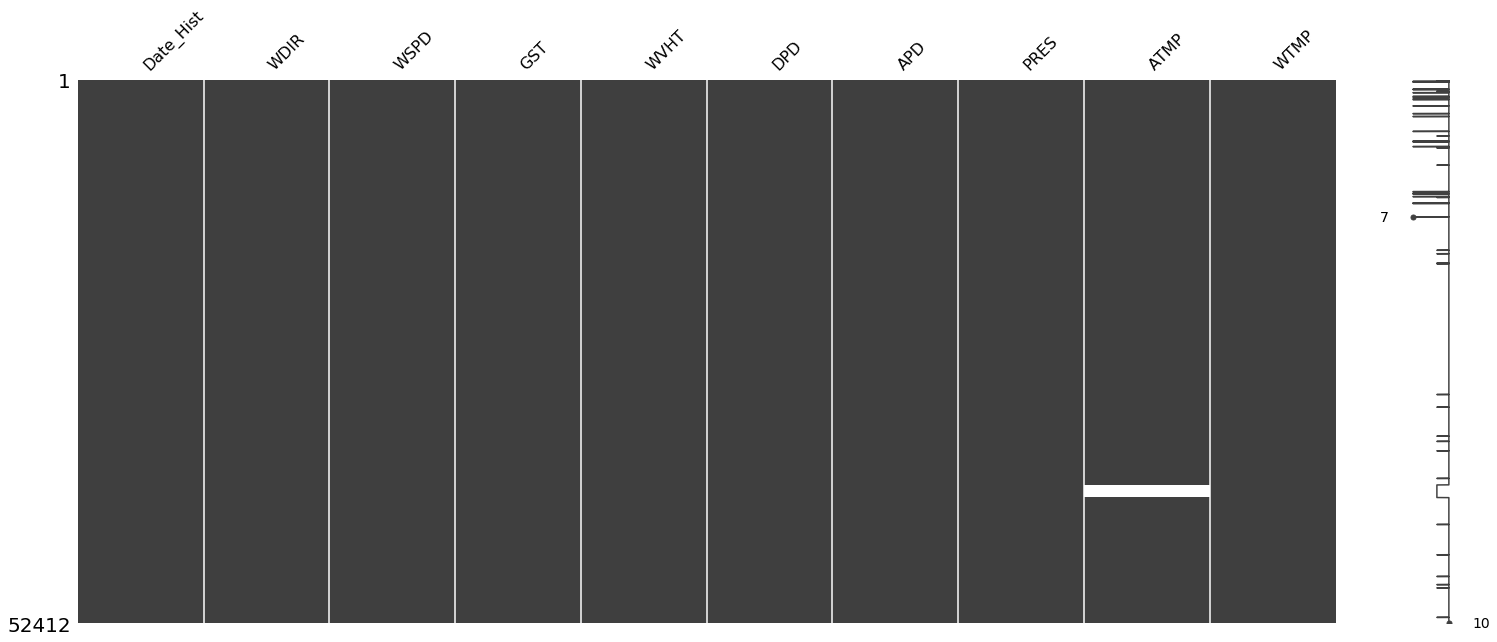

In [10]:
msno.matrix(df_46086);

### Function to merge Meteorological & Currents data

In [87]:
def merge_currents(df_temp, station):
    try:
        currents = pd.read_excel('Currents_Data.xlsx',header=[0,1])
        currents.reset_index(drop=True,inplace=True)
        rename_col = dict(zip(currents.columns.levels[1],['DateHour', 'u', 'v']))
        currents.rename(columns=rename_col,level=1, inplace=True)

        df_left = df_temp.set_index('Date_Hist')
        df_right = currents[[(station,'u'),(station,'v'),('DateObserved','DateHour')]].set_index(('DateObserved','DateHour'))
        df_temp_merged = df_left.join(df_right,how='left')
        df_temp_merged.rename(columns={df_temp_merged.columns[-2]:'u',df_temp_merged.columns[-1]:'v'},inplace=True)
        df_temp_merged.reset_index(inplace=True)
        return df_temp_merged
    except Exception as e:
        print("Exception occurred:",e)
        return None
    

In [92]:
df_46086_merged = merge_currents(df_46086, '46086')

C:\Users\HPHP\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:543: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [93]:
df_46086_merged.shape
df_46086_merged.head()

(52412, 12)

,Date_Hist,WDIR,WSPD,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v
0,2013-01-01 00:00:00,242.0,4.3,5.3,1.59,12.12,6.69,1022.1,14.3,15.7,NaN,NaN
1,2013-01-01 01:00:00,242.0,4.5,5.3,1.60,12.90,6.99,1022.6,13.8,15.7,NaN,NaN
2,2013-01-01 02:00:00,260.0,4.3,5.8,1.48,10.81,6.82,1022.8,13.5,15.6,NaN,NaN
3,2013-01-01 03:00:00,271.0,2.5,3.9,1.62,12.90,7.62,1023.2,13.3,15.6,0.014944,-0.174077
4,2013-01-01 04:00:00,275.0,2.0,3.1,1.58,19.05,7.69,1023.6,13.2,15.6,NaN,NaN


In [94]:
df_46086_merged.to_csv('df_46086_merged.csv',index=False)

### Re-loading final data from 46086 station

In [95]:
df_46086_merged = pd.read_csv('df_46086_merged.csv',parse_dates=['Date_Hist'])

In [96]:
df_46086_merged.shape

(52412, 12)

In [97]:
df_46086_merged['WDIR'].describe()

count    52391.000000
mean       259.177817
std         81.425460
min          1.000000
25%        252.000000
50%        287.000000
75%        304.000000
max        360.000000
Name: WDIR, dtype: float64

#### Converting wind directions from "Meteorological Convention" to "Mathematical Convention"

In [98]:
df_46086_merged['WDIR_Math'] = df_46086_merged['WDIR'].apply(lambda x: 270.0-x if x<=270.0 else 630.0-x)

In [99]:
df_46086_merged[['WDIR','WDIR_Math']].head(10)

,WDIR,WDIR_Math
0,242.0,28.0
1,242.0,28.0
2,260.0,10.0
3,271.0,359.0
4,275.0,355.0
5,259.0,11.0
6,249.0,21.0
7,142.0,128.0
8,158.0,112.0
9,150.0,120.0


In [100]:
df_46086_merged['WDIR_Math'].describe()

count    52391.000000
mean       250.977935
std        121.931912
min          0.000000
25%        174.000000
50%        318.000000
75%        337.000000
max        359.000000
Name: WDIR_Math, dtype: float64

#### Creating u, v components for wind from "WSPD" and "WDIR_Math" columns

In [101]:
df_46086_merged['u_wind'] = df_46086_merged['WSPD']*np.cos(np.deg2rad(df_46086_merged['WDIR_Math']))
df_46086_merged['v_wind'] = df_46086_merged['WSPD']*np.sin(np.deg2rad(df_46086_merged['WDIR_Math']))

In [102]:
df_46086_merged[['u_wind','v_wind']].describe()

,u_wind,v_wind
count,52391.000000,52391.000000
mean,3.006227,-1.309919
std,2.829816,2.217362
min,-10.430588,-14.712988
25%,1.051722,-2.757738
50%,2.956823,-1.423505
75%,4.877154,0.000000
max,16.262920,15.547209


#### Removing the original Wind related columns

In [103]:
df_46086_merged.drop(columns=['WDIR','WSPD','WDIR_Math'],inplace=True,axis=1)

In [104]:
df_46086_merged.head()

,Date_Hist,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,u_wind,v_wind
0,2013-01-01 00:00:00,5.3,1.59,12.12,6.69,1022.1,14.3,15.7,NaN,NaN,3.796675,2.018728
1,2013-01-01 01:00:00,5.3,1.60,12.90,6.99,1022.6,13.8,15.7,NaN,NaN,3.973264,2.112622
2,2013-01-01 02:00:00,5.8,1.48,10.81,6.82,1022.8,13.5,15.6,NaN,NaN,4.234673,0.746687
3,2013-01-01 03:00:00,3.9,1.62,12.90,7.62,1023.2,13.3,15.6,0.014944,-0.174077,2.499619,-0.043631
4,2013-01-01 04:00:00,3.1,1.58,19.05,7.69,1023.6,13.2,15.6,NaN,NaN,1.992389,-0.174311


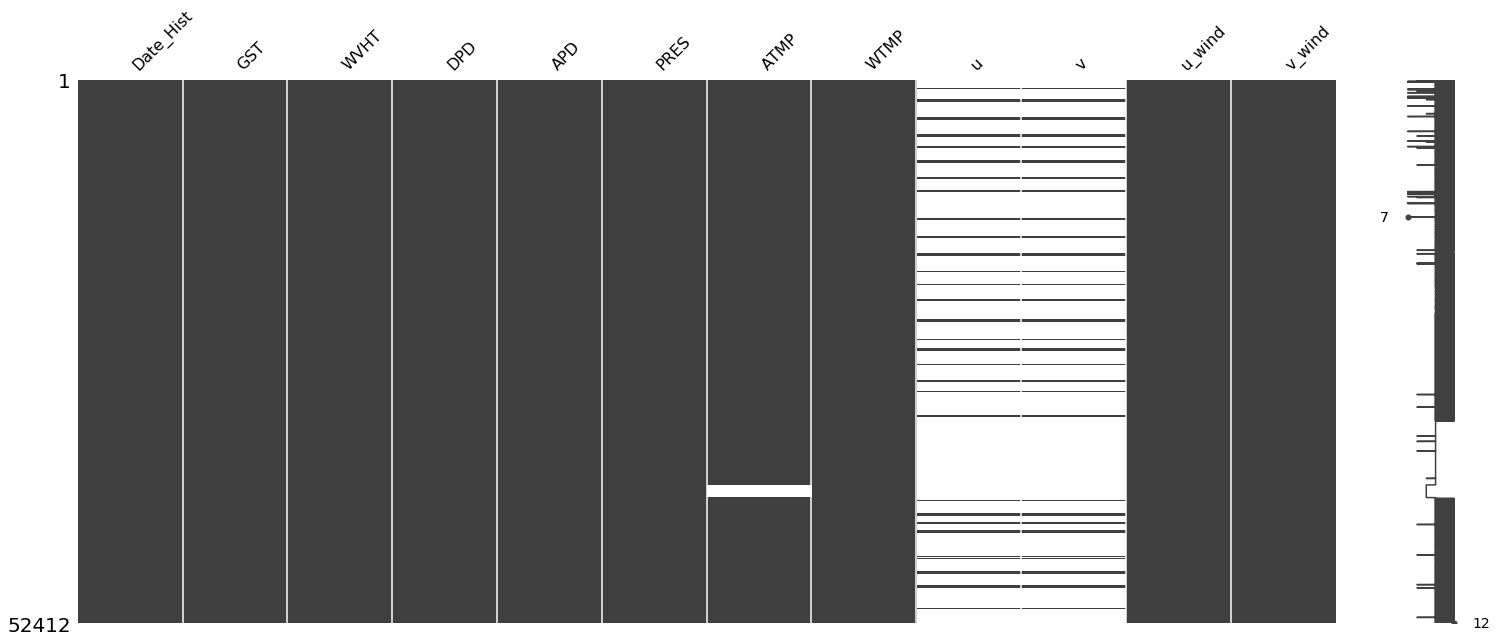

In [105]:
msno.matrix(df_46086_merged);

In [106]:
df_46086_merged.isna().sum()

Date_Hist        0
GST              0
WVHT            24
DPD             24
APD             24
PRES             1
ATMP          1223
WTMP             0
u            46072
v            46072
u_wind          21
v_wind          21
dtype: int64

### Imputing Missing Data

In [107]:
df_46086_merged.dropna(subset=['WVHT'],inplace=True)

In [108]:
df_46086_merged.isna().sum()

Date_Hist        0
GST              0
WVHT             0
DPD              0
APD              0
PRES             1
ATMP          1223
WTMP             0
u            46051
v            46051
u_wind          21
v_wind          21
dtype: int64

In [109]:
df_46086_merged['PRES'].fillna(df_46086_merged['PRES'].mean(),inplace=True)

In [110]:
df_46086_merged.isna().sum()

Date_Hist        0
GST              0
WVHT             0
DPD              0
APD              0
PRES             0
ATMP          1223
WTMP             0
u            46051
v            46051
u_wind          21
v_wind          21
dtype: int64

In [111]:
X_test_impute = df_46086_merged[df_46086_merged['ATMP'].isna()][['WTMP','PRES']]
X_test_impute.shape

(1223, 2)

In [112]:
X_train_impute = df_46086_merged[df_46086_merged['ATMP'].isna() == False][['WTMP','PRES']]
X_train_impute.shape
y_train_impute = df_46086_merged[df_46086_merged['ATMP'].isna() == False]['ATMP']
y_train_impute.shape

(51165, 2)

(51165,)

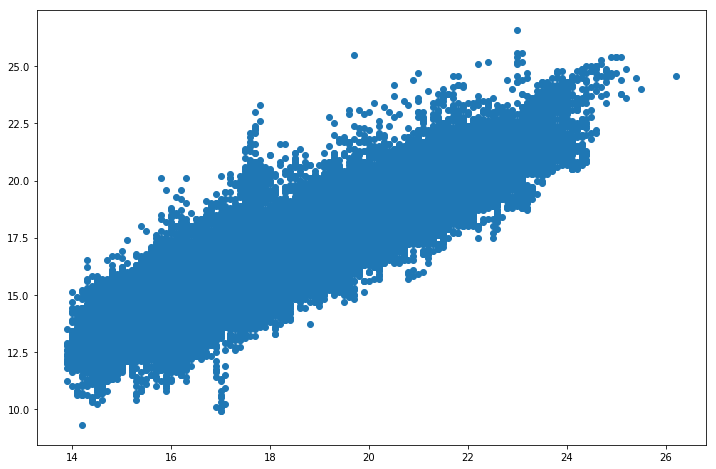

In [113]:
plt.figure(figsize=(12,8))
plt.scatter(X_train_impute['WTMP'],y_train_impute);

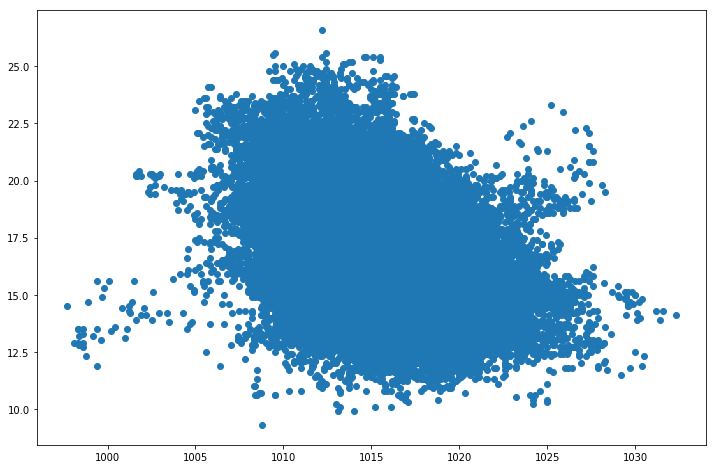

In [114]:
plt.figure(figsize=(12,8))
plt.scatter(X_train_impute['PRES'],y_train_impute);

In [116]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train_impute, y_train_impute.values.reshape(-1,1), cv=5)
scores

array([0.7397324 , 0.75304329, 0.81851224, 0.7944896 , 0.73072737])

In [117]:
lin_reg.fit(X_train_impute, y_train_impute.values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [118]:
X_train_impute.describe()

,WTMP,PRES
count,51165.000000,51165.000000
mean,18.379891,1015.291855
std,2.228871,3.619361
min,13.900000,997.700000
25%,16.700000,1012.700000
50%,18.000000,1015.000000
75%,20.000000,1017.600000
max,26.200000,1032.300000


In [122]:
df_46086_merged['ATMP']= df_46086_merged.apply(
    lambda row: 
            lin_reg.predict(pd.DataFrame({'WTMP':row.WTMP,'PRES':row.PRES},index=range(1)))[0][0]
            if np.isnan(row.ATMP) else row.ATMP, axis=1)

In [125]:
df_46086_merged.isna().sum()

Date_Hist        0
GST              0
WVHT             0
DPD              0
APD              0
PRES             0
ATMP             0
WTMP             0
u            46051
v            46051
u_wind          21
v_wind          21
dtype: int64

In [126]:
df_46086_merged['u_wind'].fillna(df_46086_merged['u_wind'].mean(),inplace=True)
df_46086_merged['v_wind'].fillna(df_46086_merged['v_wind'].mean(),inplace=True)

In [127]:
df_46086_merged.isna().sum()

Date_Hist        0
GST              0
WVHT             0
DPD              0
APD              0
PRES             0
ATMP             0
WTMP             0
u            46051
v            46051
u_wind           0
v_wind           0
dtype: int64

In [128]:
df_46086_merged.to_csv('df_46086_merged.csv',index=False)

## Reloading merged data

In [129]:
df_46086_merged = pd.read_csv('df_46086_merged.csv',parse_dates=['Date_Hist'])

In [130]:
df_46086_merged.shape
df_46086_merged.head()

(52388, 12)

,Date_Hist,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,u_wind,v_wind
0,2013-01-01 00:00:00,5.3,1.59,12.12,6.69,1022.1,14.3,15.7,NaN,NaN,3.796675,2.018728
1,2013-01-01 01:00:00,5.3,1.60,12.90,6.99,1022.6,13.8,15.7,NaN,NaN,3.973264,2.112622
2,2013-01-01 02:00:00,5.8,1.48,10.81,6.82,1022.8,13.5,15.6,NaN,NaN,4.234673,0.746687
3,2013-01-01 03:00:00,3.9,1.62,12.90,7.62,1023.2,13.3,15.6,0.014944,-0.174077,2.499619,-0.043631
4,2013-01-01 04:00:00,3.1,1.58,19.05,7.69,1023.6,13.2,15.6,NaN,NaN,1.992389,-0.174311


### Feature Engineering - Creating dummy variables for months

In [131]:
df_plots = df_46086_merged[['Date_Hist','WVHT']].groupby(pd.Grouper(key='Date_Hist',freq='M')).mean()
df_plots.head()

,WVHT
Date_Hist,
2013-01-31,1.686383
2013-02-28,1.805823
2013-03-31,1.460649
2013-04-30,1.629082
2013-05-31,1.574137


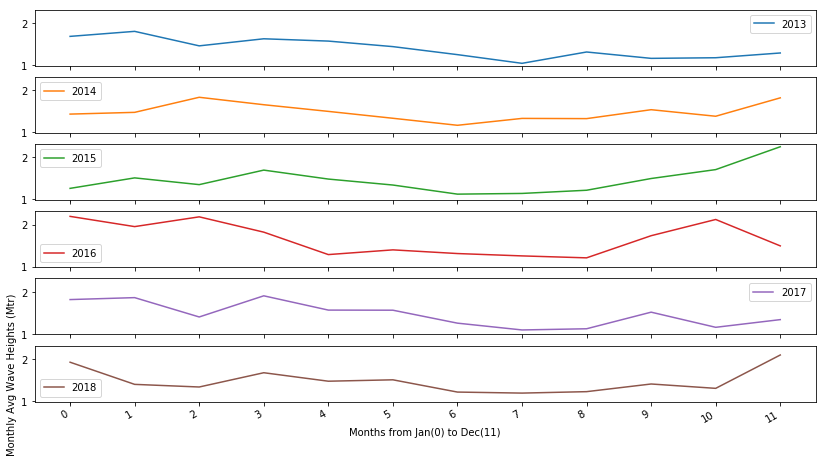

In [132]:
series = pd.Series(df_plots['WVHT'].values, index=df_plots.index.values)
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, legend=True,figsize=(14,8), sharey=True, xticks=range(0,12),)
plt.ylabel("Monthly Avg Wave Heights (Mtr)")
plt.xlabel("Months from Jan(0) to Dec(11)")
plt.show();

In [134]:
df_46086_merged['month'] = df_46086_merged['Date_Hist'].map(lambda x: x.month_name())

In [135]:
df_46086_merged.head()

,Date_Hist,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,u_wind,v_wind,month
0,2013-01-01 00:00:00,5.3,1.59,12.12,6.69,1022.1,14.3,15.7,NaN,NaN,3.796675,2.018728,January
1,2013-01-01 01:00:00,5.3,1.60,12.90,6.99,1022.6,13.8,15.7,NaN,NaN,3.973264,2.112622,January
2,2013-01-01 02:00:00,5.8,1.48,10.81,6.82,1022.8,13.5,15.6,NaN,NaN,4.234673,0.746687,January
3,2013-01-01 03:00:00,3.9,1.62,12.90,7.62,1023.2,13.3,15.6,0.014944,-0.174077,2.499619,-0.043631,January
4,2013-01-01 04:00:00,3.1,1.58,19.05,7.69,1023.6,13.2,15.6,NaN,NaN,1.992389,-0.174311,January


In [136]:
df_46086_merged.month.dtype

dtype('O')

In [137]:
df_46086_merged['month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [138]:
df_month_summies = pd.get_dummies(df_46086_merged['month'],drop_first=True, prefix='month')
df_46086_merged.shape
df_46086_merged = pd.concat([df_46086_merged,df_month_summies],axis=1)
df_46086_merged.shape

(52388, 13)

(52388, 24)

In [139]:
df_46086_merged.drop(columns=['month'],axis=1,inplace=True)

In [141]:
df_46086_merged.head(2)

,Date_Hist,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,2013-01-01 00:00:00,5.3,1.59,12.12,6.69,1022.1,14.3,15.7,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,2013-01-01 01:00:00,5.3,1.60,12.90,6.99,1022.6,13.8,15.7,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0


In [142]:
df_46086_merged.describe()

,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,u_wind,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,6337.000000,6337.000000,52388.000000,...,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000,52388.000000
mean,5.377193,1.492318,12.635049,7.263877,1015.250576,16.927382,18.413198,0.033110,-0.021859,3.004614,...,0.084714,0.077251,0.085134,0.084771,0.082061,0.084981,0.084351,0.082194,0.085058,0.082271
std,2.688483,0.589356,3.212571,1.584032,3.598029,2.367060,2.227282,0.162495,0.152107,2.828009,...,0.278458,0.266991,0.279084,0.278544,0.274460,0.278857,0.277917,0.274663,0.278970,0.274779
min,0.000000,0.310000,3.570000,3.900000,997.700000,9.300000,13.900000,-0.557990,-0.717416,-10.430588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.400000,1.100000,10.000000,6.130000,1012.700000,15.200000,16.700000,-0.072807,-0.118022,1.051722,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.350000,12.900000,6.990000,1015.000000,16.600000,18.000000,0.024536,-0.021096,2.956823,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.825000,1.730000,14.810000,8.100000,1017.600000,18.600000,20.000000,0.132414,0.075417,4.873543,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.800000,5.980000,23.530000,17.040000,1032.300000,26.600000,26.200000,0.709664,0.668087,16.262920,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [143]:
df_46086_merged.to_csv('df_46086_merged_final.csv',index=False)

## Reloading the final merged dataset

In [18]:
df_46086_merged = pd.read_csv('df_46086_merged_final.csv',parse_dates=['Date_Hist'])
df_46086_merged.shape

(52388, 23)

In [19]:
df_46086_clean = df_46086_merged.dropna(subset=['u','v'])
df_46086_clean.shape

(6337, 23)

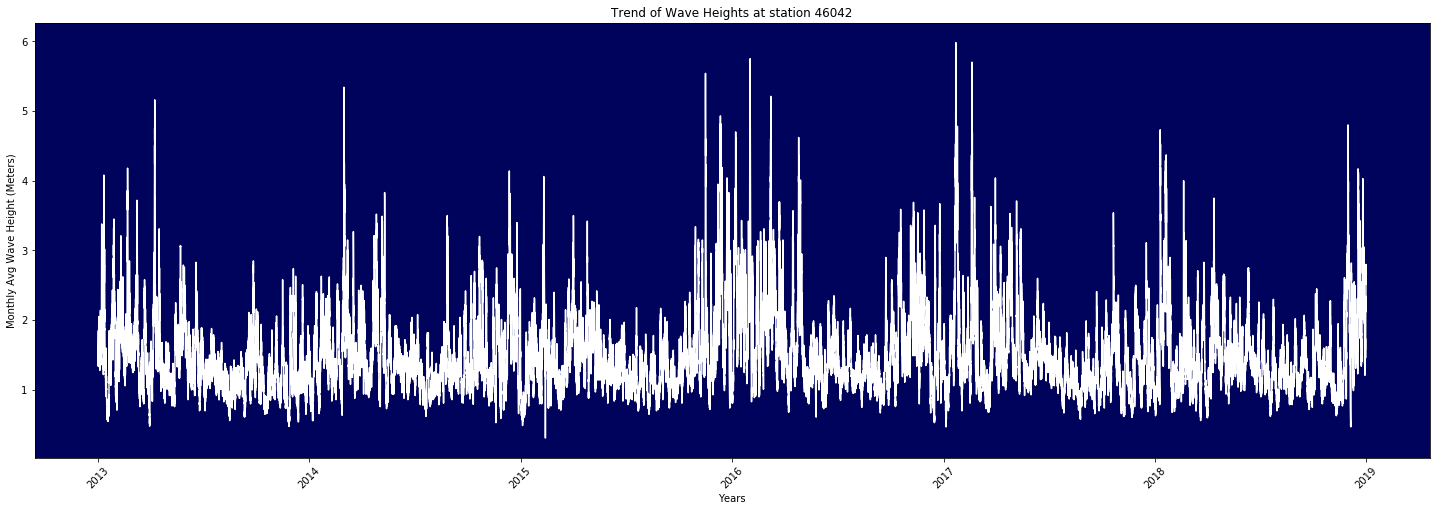

In [7]:
fig, ax = plt.subplots(figsize = (25,8))

# add the x-axis and the y-axis to the plot
ax.plot(df_46086_merged['Date_Hist'], 
        df_46086_merged['WVHT'], 
        color = 'white')

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# Setting background color
ax.set_facecolor('xkcd:dark blue')

# set title and labels for axes
ax.set(xlabel="Years",
       ylabel="Monthly Avg Wave Height (Meters)",
       title="Trend of Wave Heights at station 46042");

In [8]:
df_46086_clean.dtypes

Date_Hist          datetime64[ns]
GST                       float64
WVHT                      float64
DPD                       float64
APD                       float64
PRES                      float64
ATMP                      float64
WTMP                      float64
u                         float64
v                         float64
u_wind                    float64
v_wind                    float64
month_August                int64
month_December              int64
month_February              int64
month_January               int64
month_July                  int64
month_June                  int64
month_March                 int64
month_May                   int64
month_November              int64
month_October               int64
month_September             int64
dtype: object

In [9]:
df_46086_clean.describe()

,GST,WVHT,DPD,APD,PRES,ATMP,WTMP,u,v,u_wind,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,...,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000,6337.000000
mean,5.346079,1.471504,12.703364,7.261823,1015.221966,17.015260,18.531040,0.033110,-0.021859,2.968701,...,0.088843,0.075272,0.085845,0.076535,0.071643,0.083162,0.074010,0.080638,0.088843,0.105413
std,2.648418,0.591650,3.212028,1.613878,3.583208,2.419073,2.293896,0.162495,0.152107,2.778547,...,0.284540,0.263851,0.280157,0.265873,0.257916,0.276149,0.261807,0.272299,0.284540,0.307109
min,0.100000,0.470000,4.000000,4.040000,1001.700000,9.900000,13.900000,-0.557990,-0.717416,-8.768124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,1.080000,10.810000,6.100000,1012.700000,15.300000,16.700000,-0.072807,-0.118022,1.060262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.330000,12.900000,6.970000,1014.900000,16.700000,18.200000,0.024536,-0.021096,2.917565,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.800000,1.700000,14.810000,8.110000,1017.600000,18.800000,20.300000,0.132414,0.075417,4.793422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.400000,5.740000,23.530000,14.990000,1029.200000,25.300000,25.100000,0.709664,0.668087,15.461482,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


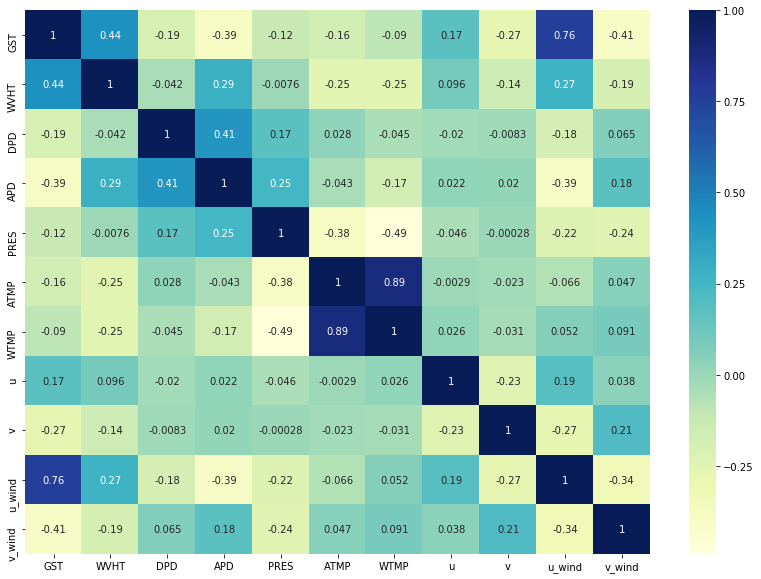

In [146]:
corr = df_46086_merged.corr()
fig, ax = plt.subplots(figsize=(14, 10))
ax.tick_params(labelsize=10)
sns.heatmap(corr, annot=True,annot_kws={"size": 10},cmap='YlGnBu')
plt.savefig("Correlation_46086_output_0505.png")
plt.show();

In [11]:
y = df_46086_clean['WVHT']
x = df_46086_clean.drop(columns=['Date_Hist','WVHT','DPD','APD'])

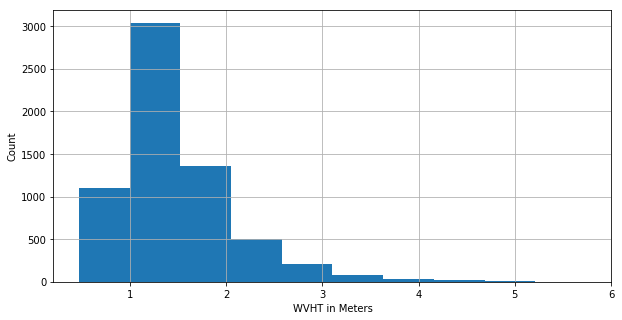

In [14]:
plt.figure(figsize=(10,5))
y.hist()
plt.xlabel('WVHT in Meters')
plt.ylabel('Count');

### y-variable 'WDIR' is highly right-skewed. To make it normally distributed, we'll apply log-transformation.

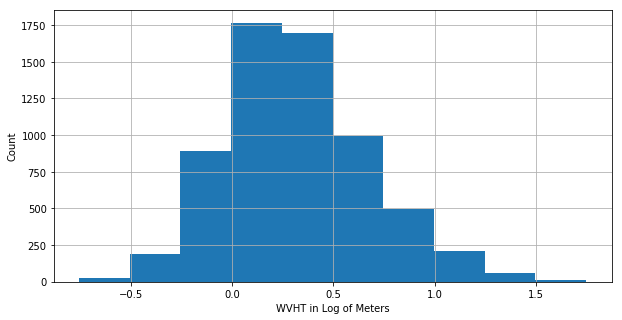

In [17]:
# Applying natural logarithm
ln_y = np.log(y)
plt.figure(figsize=(10,5))
ln_y.hist()
plt.xlabel('WVHT in Log of Meters')
plt.ylabel('Count');

#### Log transformation makes ot normally-distributed (almost).

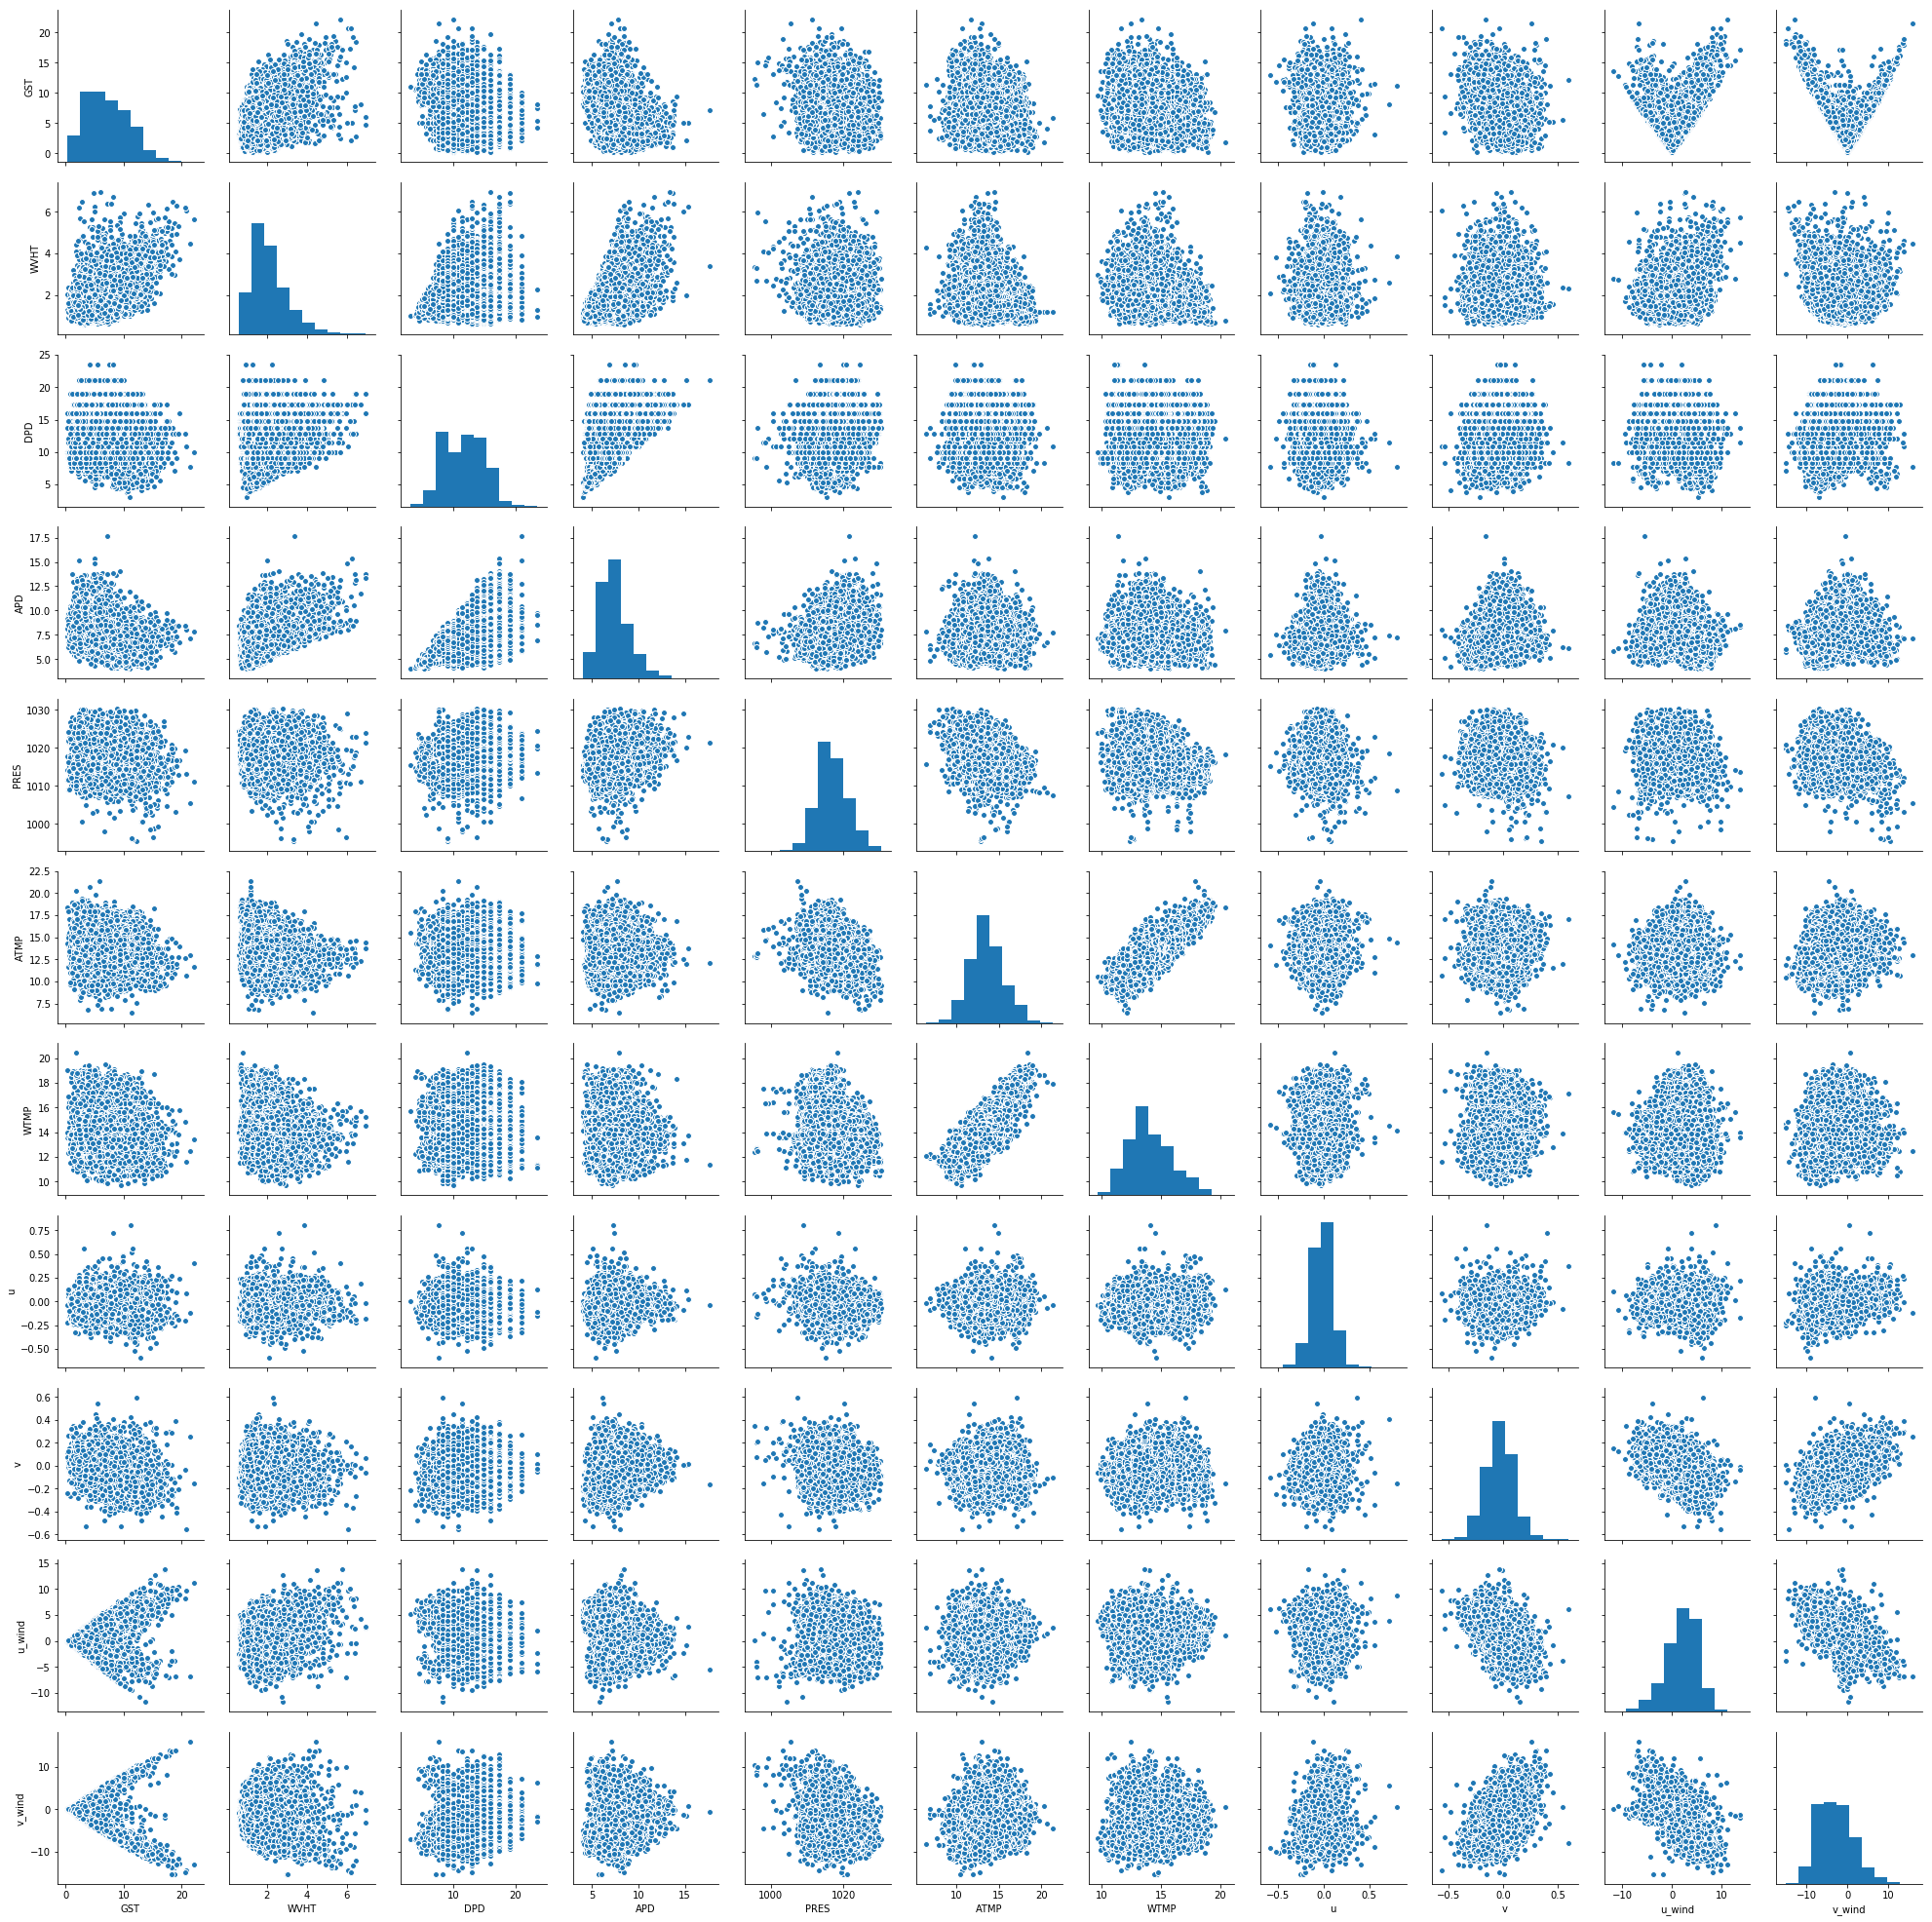

In [39]:
sns.pairplot(df_46042_clean);

## 1. Lasso Regression

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [22]:
cv_pipeline = make_pipeline(StandardScaler(),Lasso(alpha = 0.001, max_iter = 1000))

In [29]:
scores = cross_val_score(cv_pipeline, x, ln_y, cv=5,scoring='neg_mean_squared_error')

In [30]:
scores

array([-0.11845331, -0.15601419, -0.08997252, -0.11544037, -0.2253994 ])

In [31]:
scores.mean()

-0.14105595626740014

In [70]:
lasso_reg = Lasso()
param_grid = {'alpha':[0.001,0.01,0.1,1,2],
             'max_iter':[1000, 2000, 5000, 10000]}

gs_lasso = GridSearchCV(lasso_reg, param_grid, cv=5)
gs_lasso.fit(x, ln_y)
gs_lasso.best_params_

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2], 'max_iter': [1000, 2000, 5000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'alpha': 0.001, 'max_iter': 1000}

In [71]:
lasso_reg_best = Lasso(alpha = 0.001, max_iter = 1000)

In [72]:
errors = cross_val_score(lasso_reg_best,x,ln_y,cv=5,scoring='neg_mean_squared_error')
errors
errors.mean()

array([-0.07019096, -0.07253683, -0.05361344, -0.0679129 , -0.08516873])

-0.06988457134955771

In [73]:
scores = cross_val_score(lasso_reg_best,x,ln_y,cv=5,scoring='r2')
scores
scores.mean()

array([0.57165815, 0.55200714, 0.56021143, 0.54758324, 0.55373728])

0.5570394458088893

# 2. ANN

In [235]:
df_46086_currents = df_46086_merged.dropna(subset=['u','v'])
df_46086_currents.shape

(6337, 23)

In [236]:
y = df_46086_currents['WVHT']
x = df_46086_currents.drop(columns=['Date_Hist','WVHT','DPD','APD'])

In [237]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=10)

In [238]:
x_train.shape
x_test.shape

(5386, 19)

(951, 19)

### Standardizing the features

In [239]:
std_scaler = StandardScaler()

x_train_std = x_train.drop(columns=['GST','PRES','ATMP','WTMP'],axis=1)
x_test_std = x_test.drop(columns=['GST','PRES','ATMP','WTMP'],axis=1)

x_train_std_test = pd.DataFrame(std_scaler.fit_transform(x_train[['GST','PRES','ATMP','WTMP']]),columns=['GST','PRES','ATMP','WTMP'])

std_scaler_test = StandardScaler()
x_test_std_test = pd.DataFrame(std_scaler_test.fit_transform(x_test[['GST','PRES','ATMP','WTMP']]),columns=['GST','PRES','ATMP','WTMP'])

In [240]:
x_train_std_test.reset_index(drop=True,inplace=True)
x_test_std_test.reset_index(drop=True,inplace=True)

x_train_std.reset_index(drop=True,inplace=True)
x_test_std.reset_index(drop=True,inplace=True)

In [241]:
x_train_std = pd.concat([x_train_std_test,x_train_std], axis=1)
x_test_std = pd.concat([x_test_std_test,x_test_std], axis=1)

In [242]:
x_train_std.shape
x_test_std.shape

(5386, 19)

(951, 19)

In [243]:
x_train_std.describe()
x_test_std.describe()

,GST,PRES,ATMP,WTMP,u,v,u_wind,v_wind,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,5.386000e+03,5.386000e+03,5.386000e+03,5.386000e+03,5386.000000,5386.000000,5386.000000,5.386000e+03,5386.000000,5386.000000,5386.000000,5386.000000,5386.000000,5386.00000,5386.000000,5386.000000,5386.000000,5386.000000,5386.000000
mean,-2.130109e-17,2.624105e-14,-2.062730e-17,4.289798e-16,0.032886,-0.021287,2.961988,-1.313004e+00,0.098032,0.088749,0.074452,0.086892,0.073524,0.07241,0.082436,0.073338,0.080208,0.090048,0.105273
std,1.000093e+00,1.000093e+00,1.000093e+00,1.000093e+00,0.163089,0.152079,2.774722,2.220548e+00,0.297385,0.284407,0.262530,0.281703,0.261019,0.25919,0.275053,0.260715,0.271640,0.286277,0.306933
min,-1.993213e+00,-3.762141e+00,-2.959600e+00,-2.008464e+00,-0.557990,-0.717416,-8.768124,-1.104848e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.998958e-01,-7.029281e-01,-7.133594e-01,-7.935995e-01,-0.073922,-0.117189,1.070174,-2.742702e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.673535e-01,-9.108550e-02,-1.310006e-01,-1.427793e-01,0.024064,-0.019525,2.912461,-1.413998e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.553825e-01,6.598122e-01,7.425376e-01,7.683691e-01,0.133383,0.074270,4.791813,2.296213e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.728651e+00,3.885891e+00,3.446346e+00,2.850994e+00,0.709664,0.668087,15.461482,1.103684e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


,GST,PRES,ATMP,WTMP,u,v,u_wind,v_wind,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,9.510000e+02,9.510000e+02,9.510000e+02,9.510000e+02,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,-1.831401e-16,1.547541e-15,8.013219e-16,4.105841e-16,0.034377,-0.025098,3.006716,-1.438090,0.083070,0.089380,0.079916,0.079916,0.093586,0.067298,0.087277,0.077813,0.083070,0.082019,0.106204
std,1.000526e+00,1.000526e+00,1.000526e+00,1.000526e+00,0.159167,0.152305,2.801280,2.230209,0.276134,0.285441,0.271306,0.271306,0.291405,0.250668,0.282388,0.268018,0.276134,0.274538,0.308261
min,-1.844355e+00,-2.419262e+00,-2.525433e+00,-2.036886e+00,-0.463769,-0.470114,-7.229759,-9.800718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.190307e-01,-7.096442e-01,-7.264466e-01,-7.812560e-01,-0.065549,-0.124635,0.992525,-2.862670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.382179e-01,-8.278433e-02,-1.267845e-01,-1.085968e-01,0.026276,-0.031911,2.966020,-1.514711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.514973e-01,6.580500e-01,7.527199e-01,7.434381e-01,0.123334,0.080583,4.821356,-0.016580,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.653488e+00,3.678375e+00,3.111391e+00,2.626884e+00,0.573653,0.485216,14.248941,9.950909,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [244]:
y_train.describe()

count    5386.000000
mean        1.468962
std         0.592438
min         0.470000
25%         1.080000
50%         1.330000
75%         1.690000
max         5.740000
Name: WVHT, dtype: float64

In [245]:
def build_model():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(x_train_std.keys())]),
    layers.Dense(20, activation=tf.nn.relu),
    layers.Dense(20, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(lr=0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [246]:
model1 = build_model()

In [247]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                400       
_________________________________________________________________
dense_17 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 21        
Total params: 1,261
Trainable params: 1,261
Non-trainable params: 0
_________________________________________________________________


In [248]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model1.fit(
  x_train_std, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [249]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
495,0.231506,0.353069,0.231506,0.103432,0.239752,0.103432,495
496,0.233644,0.356917,0.233644,0.102920,0.238190,0.102920,496
497,0.239790,0.363373,0.239790,0.104891,0.241517,0.104891,497
498,0.229017,0.351771,0.229017,0.102099,0.238498,0.102099,498
499,0.233426,0.355371,0.233426,0.101247,0.236108,0.101247,499


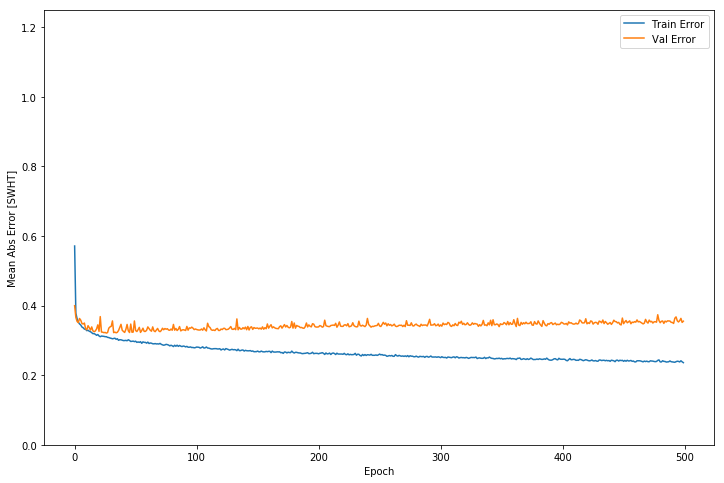

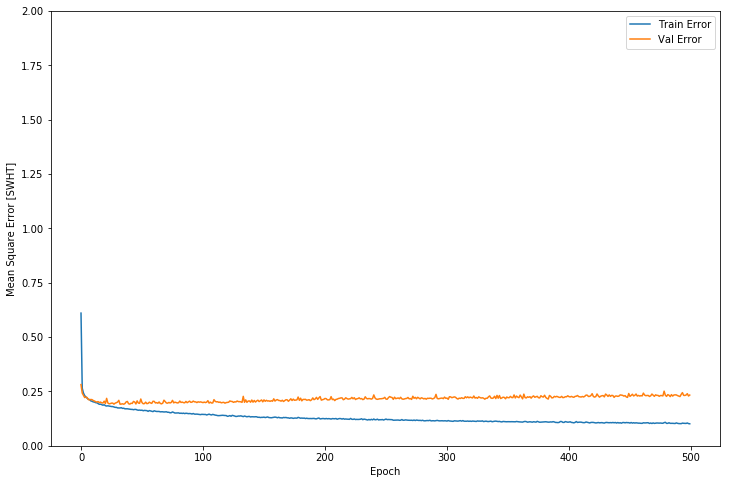

In [250]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(12,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [SWHT]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.25])
  plt.legend()
  
  plt.figure(figsize=(12,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [SWHT]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()
  plt.show()


plot_history(history)


...........................................

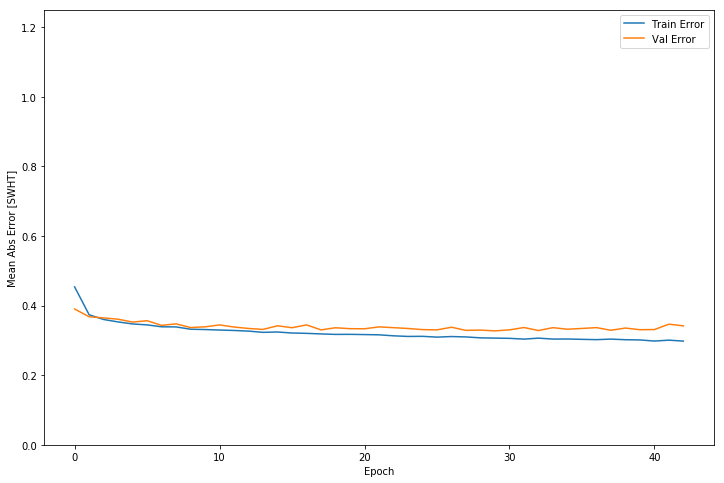

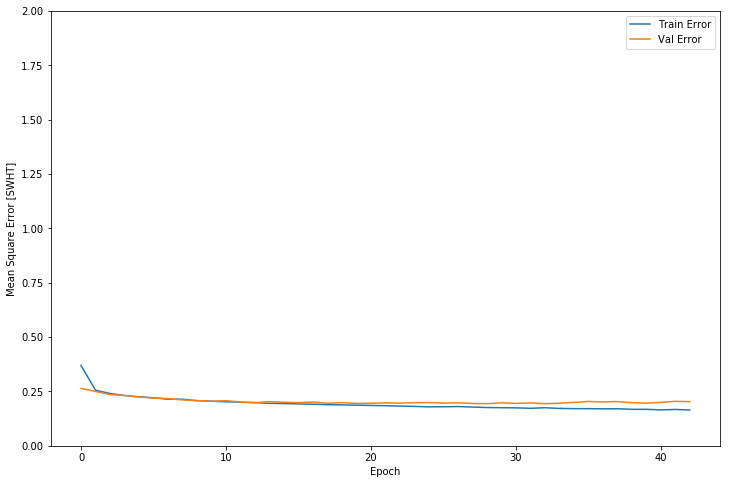

In [251]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train_std, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [252]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
38,0.198303,0.335543,0.198303,0.167748,0.302048,0.167748,38
39,0.196108,0.330847,0.196108,0.167807,0.301431,0.167807,39
40,0.199597,0.331222,0.199597,0.165158,0.298201,0.165158,40
41,0.204583,0.346664,0.204583,0.167202,0.300773,0.167202,41
42,0.202786,0.341891,0.202786,0.164475,0.298063,0.164475,42


In [253]:
loss, mae, mse = model.evaluate(x_test_std, y_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Squared Error: {:5.2f}".format(mse))

Testing set Mean Abs Error:  0.33
Testing set Mean Squared Error:  0.19


In [254]:
y_test.describe()

count    951.000000
mean       1.485899
std        0.587267
min        0.500000
25%        1.090000
50%        1.340000
75%        1.735000
max        4.600000
Name: WVHT, dtype: float64

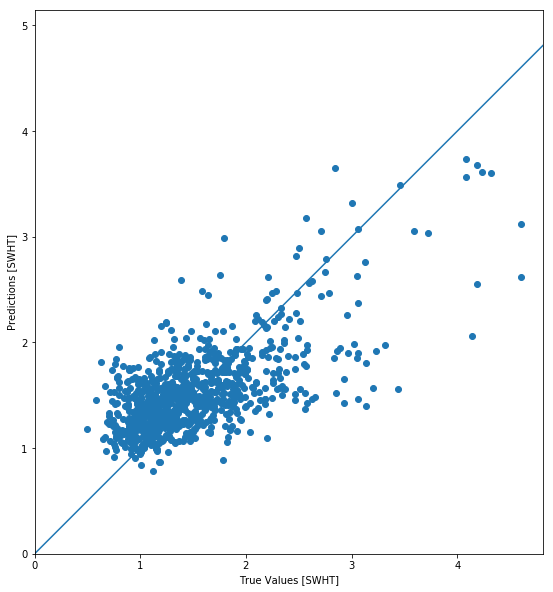

In [255]:
test_predictions = model.predict(x_test_std).flatten()

plt.figure(figsize=(16,10))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [SWHT]')
plt.ylabel('Predictions [SWHT]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100]);

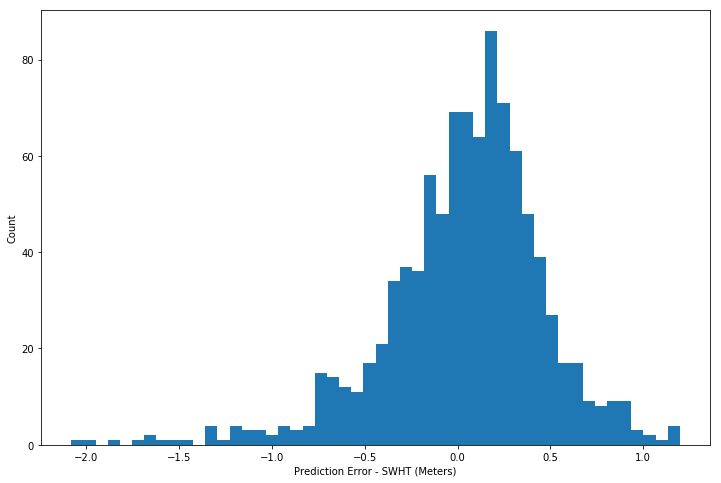

In [256]:
errors = test_predictions - y_test
plt.figure(figsize=(12,8))
plt.hist(errors, bins = 50)
plt.xlabel("Prediction Error - SWHT (Meters)")
_ = plt.ylabel("Count");

### Interpolation of u & v components of "currents"

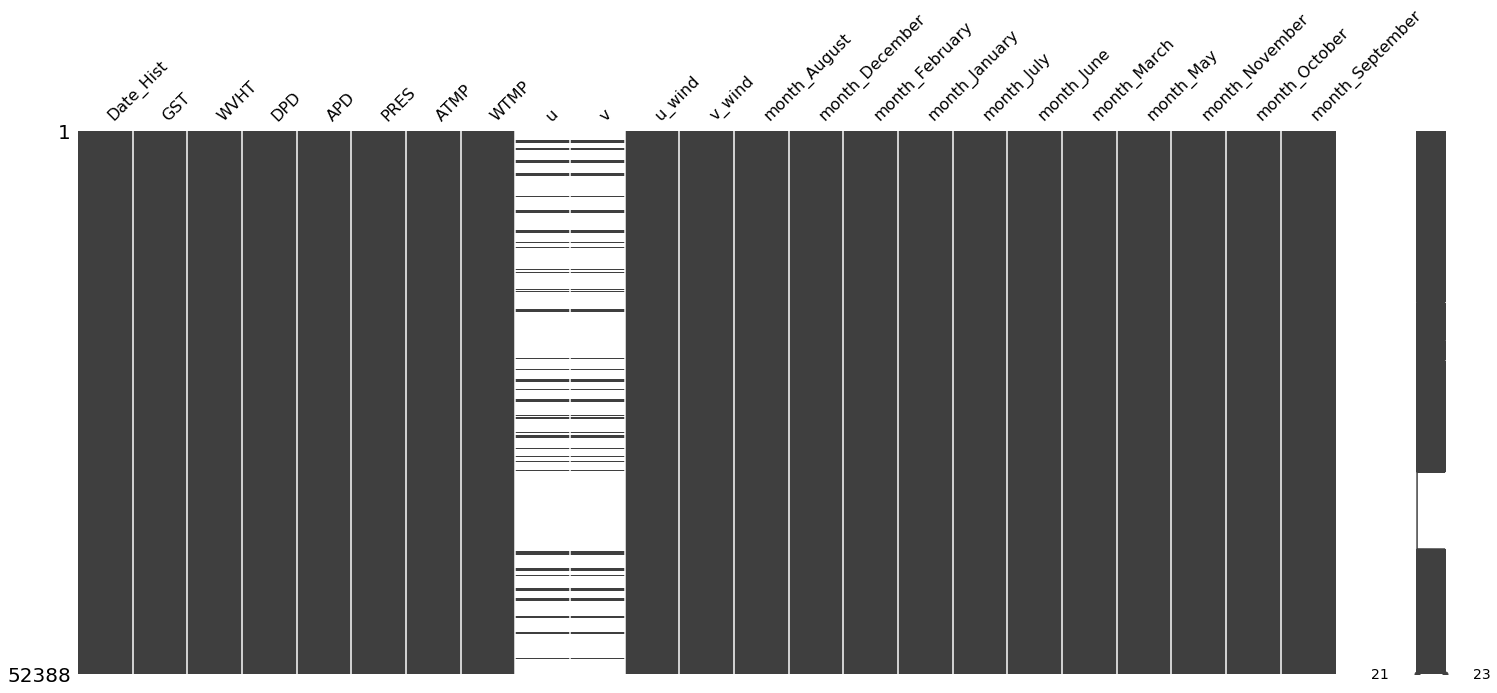

In [257]:
msno.matrix(df_46086_merged)

# ANN - Without currents data

In [20]:
df_46086_noCurrents = df_46086_merged.drop(columns=['u','v'],axis=1)
df_46086_noCurrents.shape

(52388, 21)

In [21]:
df_46086_merged.shape

(52388, 23)

In [22]:
y = df_46086_noCurrents['WVHT']
x = df_46086_noCurrents.drop(columns=['Date_Hist','WVHT','DPD','APD'])

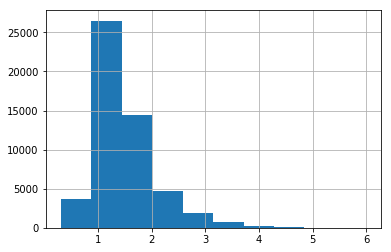

In [23]:
y.hist();

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=10)

In [25]:
x_train.shape
y_train.shape

(41910, 17)

(41910,)

### Standardizing the features

In [26]:
x_train.describe()

,GST,PRES,ATMP,WTMP,u_wind,v_wind,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000
mean,5.379069,1015.268896,16.926645,18.409866,3.008252,-1.318227,0.084896,0.085111,0.077380,0.085636,0.083178,0.082582,0.084634,0.084133,0.082128,0.086137,0.081985
std,2.682086,3.594826,2.370407,2.229675,2.824369,2.211311,0.278731,0.279050,0.267197,0.279829,0.276155,0.275252,0.278339,0.277590,0.274563,0.280570,0.274345
min,0.000000,997.700000,9.300000,13.900000,-9.615878,-14.712988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,1012.700000,15.200000,16.700000,1.057515,-2.763415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1015.000000,16.600000,18.000000,2.966020,-1.432621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.800000,1017.600000,18.600000,20.000000,4.871850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,23.800000,1032.300000,25.600000,26.200000,15.880805,15.547209,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
std_scaler = StandardScaler()

x_train_std = x_train.drop(columns=['GST','PRES','ATMP','WTMP'],axis=1)
x_test_std = x_test.drop(columns=['GST','PRES','ATMP','WTMP'],axis=1)

x_train_std_test = pd.DataFrame(std_scaler.fit_transform(x_train[['GST','PRES','ATMP','WTMP']]),columns=['GST','PRES','ATMP','WTMP'])

std_scaler_test = StandardScaler()
x_test_std_test = pd.DataFrame(std_scaler_test.fit_transform(x_test[['GST','PRES','ATMP','WTMP']]),columns=['GST','PRES','ATMP','WTMP'])

In [28]:
x_train_std_test.reset_index(drop=True,inplace=True)
x_test_std_test.reset_index(drop=True,inplace=True)

x_train_std.reset_index(drop=True,inplace=True)
x_test_std.reset_index(drop=True,inplace=True)

In [29]:
x_train_std = pd.concat([x_train_std_test,x_train_std], axis=1)
x_test_std = pd.concat([x_test_std_test,x_test_std], axis=1)

In [30]:
x_train_std.describe()
x_test_std.describe()

,GST,PRES,ATMP,WTMP,u_wind,v_wind,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,4.191000e+04,4.191000e+04,4.191000e+04,4.191000e+04,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000,41910.000000
mean,-9.191195e-17,-2.830737e-14,1.160672e-15,1.014295e-15,3.008252,-1.318227,0.084896,0.085111,0.077380,0.085636,0.083178,0.082582,0.084634,0.084133,0.082128,0.086137,0.081985
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,2.824369,2.211311,0.278731,0.279050,0.267197,0.279829,0.276155,0.275252,0.278339,0.277590,0.274563,0.280570,0.274345
min,-2.005579e+00,-4.887332e+00,-3.217480e+00,-2.022681e+00,-9.615878,-14.712988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.006085e-01,-7.146180e-01,-7.284260e-01,-7.668772e-01,1.057515,-2.763415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.413355e-01,-7.480187e-02,-1.378030e-01,-1.838256e-01,2.966020,-1.432621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.297920e-01,6.484686e-01,7.059441e-01,7.131769e-01,4.871850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.868219e+00,4.737728e+00,3.659059e+00,3.493885e+00,15.880805,15.547209,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,GST,PRES,ATMP,WTMP,u_wind,v_wind,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
count,1.047800e+04,1.047800e+04,1.047800e+04,1.047800e+04,10478.000000,1.047800e+04,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000
mean,1.832112e-16,2.285414e-14,7.831533e-16,6.186225e-16,2.990062,-1.270307e+00,0.085131,0.083127,0.076732,0.083127,0.091143,0.079977,0.086371,0.085226,0.082458,0.080741,0.083413
std,1.000048e+00,1.000048e+00,1.000048e+00,1.000048e+00,2.842611,2.235121e+00,0.279089,0.276087,0.266179,0.276087,0.287827,0.271271,0.280925,0.279231,0.275075,0.272449,0.276518
min,-1.941734e+00,-4.730705e+00,-2.987022e+00,-2.041147e+00,-10.430588,-1.448889e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.257758e-01,-6.862535e-01,-7.351765e-01,-7.785417e-01,1.019782,-2.703202e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.362201e-01,-7.681557e-02,-1.403494e-01,-1.472389e-01,2.937834,-1.386044e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.638772e-01,6.434292e-01,7.518912e-01,7.095293e-01,4.881354,1.928819e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.275198e+00,4.189250e+00,4.108416e+00,2.964182e+00,16.262920,1.417577e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
y_train.describe()

count    41910.000000
mean         1.492954
std          0.589168
min          0.470000
25%          1.100000
50%          1.350000
75%          1.730000
max          5.980000
Name: WVHT, dtype: float64

In [221]:
def build_model():
  model = keras.Sequential([
    layers.Dense(20, activation=tf.nn.relu, input_shape=[len(x_train_std.keys())]),
    layers.Dense(20, activation=tf.nn.relu),
    layers.Dense(20, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.Adam(lr=0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [222]:
model2 = build_model()

In [223]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                360       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________


In [224]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

history = model2.fit(
  x_train_std, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [225]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
495,0.155458,0.287958,0.155458,0.132995,0.270995,0.132995,495
496,0.154630,0.286345,0.154630,0.132836,0.270773,0.132836,496
497,0.153022,0.288372,0.153022,0.132595,0.270573,0.132595,497
498,0.157849,0.295041,0.157849,0.132497,0.270445,0.132497,498
499,0.156231,0.286375,0.156231,0.132404,0.270766,0.132404,499


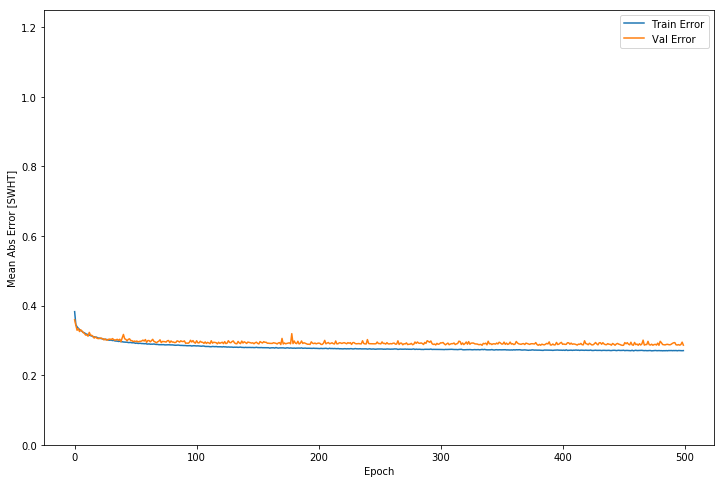

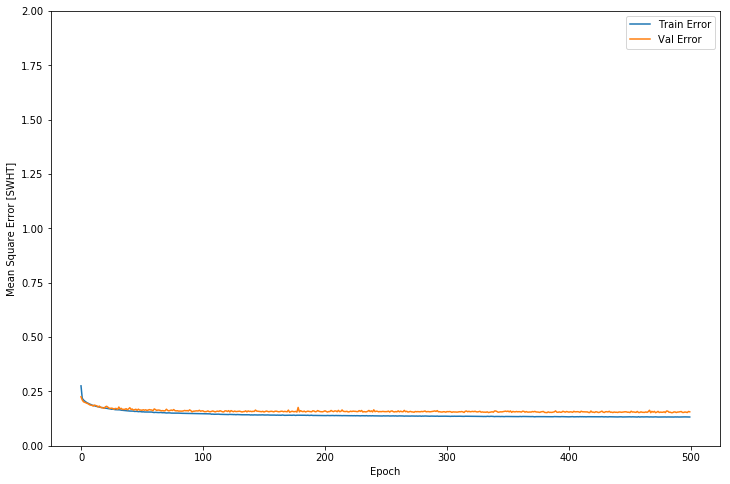

In [226]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure(figsize=(12,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [SWHT]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,1.25])
  plt.legend()
  
  plt.figure(figsize=(12,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [SWHT]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()
  plt.show()


plot_history(history)


...........................................

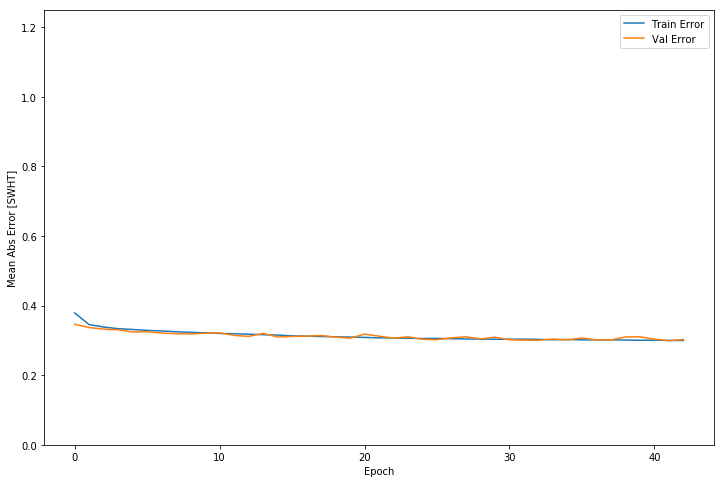

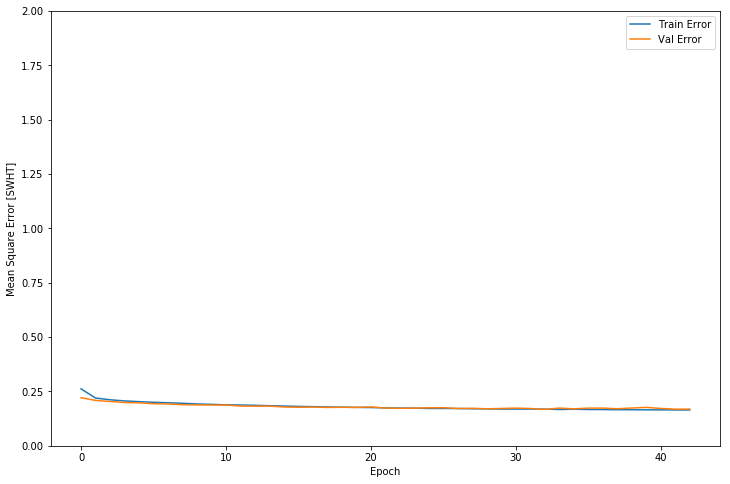

In [227]:
model3 = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model3.fit(x_train_std, y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [228]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
38,0.173690,0.309906,0.173690,0.166044,0.301127,0.166044,38
39,0.176829,0.310439,0.176829,0.165397,0.300424,0.165397,39
40,0.171828,0.303603,0.171828,0.165282,0.300771,0.165282,40
41,0.168490,0.299389,0.168490,0.164760,0.299882,0.164760,41
42,0.168992,0.302757,0.168992,0.164708,0.300063,0.164708,42


In [229]:
loss, mae, mse = model2.evaluate(x_test_std, y_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Squared Error: {:5.2f}".format(mse))

Testing set Mean Abs Error:  0.30
Testing set Mean Squared Error:  0.17


In [72]:
y_test.describe()

count    7743.000000
mean        2.136120
std         0.929815
min         0.560000
25%         1.460000
50%         1.930000
75%         2.590000
max         8.920000
Name: WVHT, dtype: float64

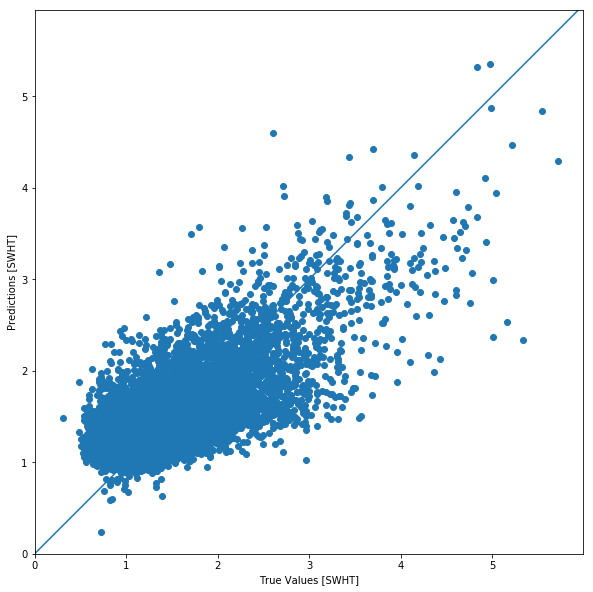

In [230]:
test_predictions = model2.predict(x_test_std).flatten()

plt.figure(figsize=(16,10))
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [SWHT]')
plt.ylabel('Predictions [SWHT]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100]);

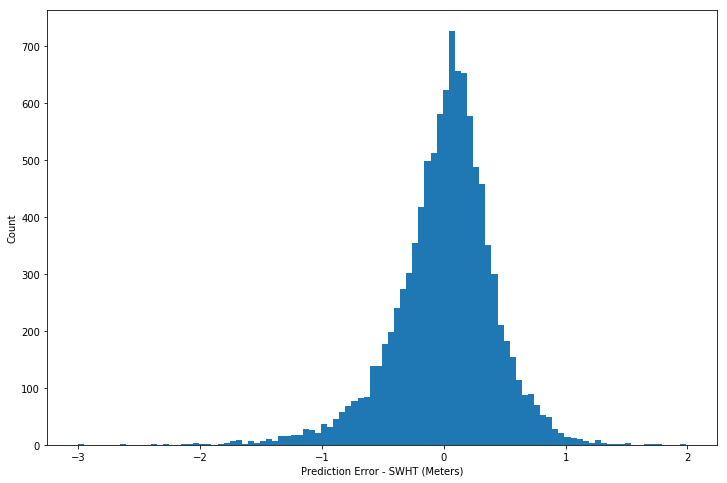

In [231]:
errors = test_predictions - y_test
plt.figure(figsize=(12,8))
plt.hist(errors, bins = 100)
plt.xlabel("Prediction Error - SWHT (Meters)")
plt.yticks()
_ = plt.ylabel("Count");

In [211]:
df_plots = df_46042_merged[['Date_Hist','WVHT']].groupby(pd.Grouper(key='Date_Hist',freq='M')).mean()
df_plots.head()

,WVHT
Date_Hist,
2013-01-31,2.505020
2013-02-28,2.921450
2013-03-31,2.155155
2013-04-30,2.377497
2013-05-31,1.964825


## Gradient Boosting - Without currents data

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor()
MAE_scorer = metrics.make_scorer(mean_absolute_error, greater_is_better=False)
param_grid={'n_estimators':[100, 200, 1500, 2000, 4000], 
            'alpha': [0.05, 0.02, 0.01]
           }

grid_gbm = GridSearchCV(estimator=gbm, cv=5, param_grid=param_grid, scoring=MAE_scorer)
grid_gbm.fit(x_train_std,y_train)

gbm_best = grid_gbm.best_estimator_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 200, 1500, 2000, 4000], 'alpha': [0.05, 0.02, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=0)

In [36]:
y_test.describe()

count    10478.000000
mean         1.489772
std          0.590128
min          0.310000
25%          1.100000
50%          1.350000
75%          1.720000
max          5.720000
Name: WVHT, dtype: float64

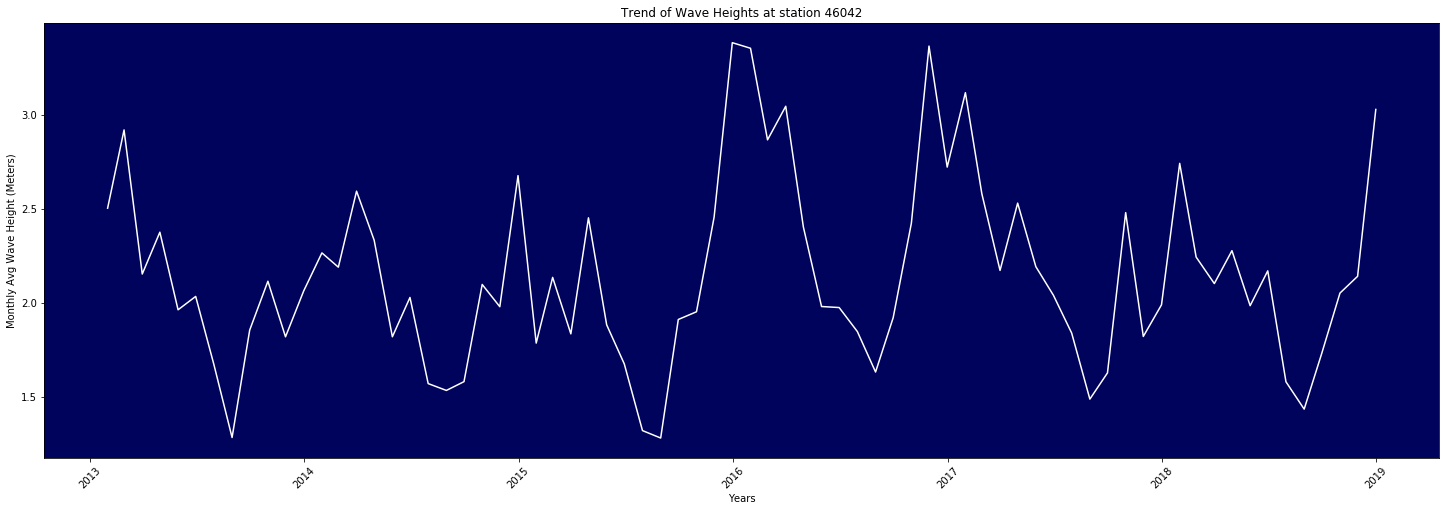

In [213]:
fig, ax = plt.subplots(figsize = (25,8))

# add the x-axis and the y-axis to the plot
ax.plot(df_plots.index, 
        df_plots['WVHT'], 
        color = 'white')

# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# Setting background color
ax.set_facecolor('xkcd:dark blue')

# set title and labels for axes
ax.set(xlabel="Years",
       ylabel="Monthly Avg Wave Height (Meters)",
       title="Trend of Wave Heights at station 46042");

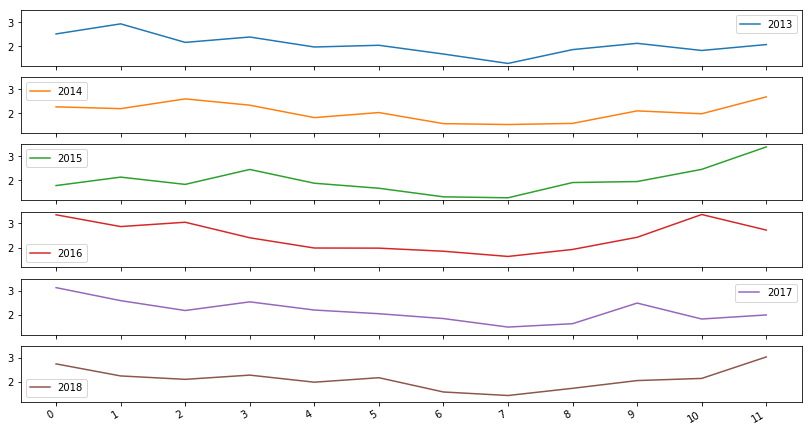

In [232]:
series = pd.Series(df_plots['WVHT'].values, index=df_plots.index.values)
groups = series.groupby(pd.Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.plot(subplots=True, legend=True,figsize=(14,8), sharey=True, xticks=range(0,12),)
plt.show();

## Archive

In [ ]:
dataset.dimensions

In [ ]:
lon = dataset.variables['lon']
lat = dataset.variables['lat']
time = dataset.variables['time']
depth = dataset.variables['depth']

for d in dataset.dimensions.items():
    print(d)

lon_array = lon[:]
lat_array = lat[:]
time_array = time[:]
depth_array = depth[:]

lon_array
lat_array
time_array
depth_array

In [ ]:
i = np.abs(lon_array - 10).argmin()
j = np.abs(lat_array - 30).argmin()
u_time = u[:,:,j,i]
u_time

In [ ]:
u[:,:,:,:]